## Regression PLS

In [1]:
library("dplyr")
library("FactoMineR")
library("pls")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings




In [2]:
data_20_stations <- read.csv("../data/mesures/donnees_extracted_metro_20.csv")
summary(data_20_stations)

 ID.OMM.station     Date           Pression.au.niveau.mer
 Min.   :7020   Length:465844      Min.   : 95780        
 1st Qu.:7149   Class :character   1st Qu.:101260        
 Median :7510   Mode  :character   Median :101730        
 Mean   :7417                      Mean   :101710        
 3rd Qu.:7650                      3rd Qu.:102230        
 Max.   :7790                      Max.   :104890        
                                   NA's   :50165         
 Variation.de.pression.en.3.heures Type.de.tendance.barométrique
 Min.   :-1780.000                 Min.   :0.000                
 1st Qu.:  -70.000                 1st Qu.:2.000                
 Median :    0.000                 Median :4.000                
 Mean   :    2.588                 Mean   :4.324                
 3rd Qu.:   70.000                 3rd Qu.:7.000                
 Max.   : 1330.000                 Max.   :8.000                
 NA's   :19075                     NA's   :19075                
 Direction.du.ve

In [3]:
clean_data <- function(
  df, 
  verbose = TRUE,
  id_cols = c(
    "ID.OMM.station", 
    "communes..code.", 
    "EPCI..code.", 
    "department..code.", 
    "region..code."
  ),
  cat_cols = c(
    "Type.de.tendance.barométrique", 
    "Temps.présent", 
    "Temps.passé.1", 
    "Temps.passé.2", 
    "Type.des.nuages.de.l.étage.inférieur", 
    "Type.des.nuages.de.l.étage.moyen", 
    "Type.des.nuages.de.l.étage.supérieur", 
    "Type.nuage.1", 
    "Type.nuage.2", 
    "Type.nuage.3", 
    "Type.nuage.4", 
    "mois_de_l_annee", 
    "Nebulosité.totale", 
    "Nébulosité..des.nuages.de.l..étage.inférieur", 
    "Nébulosité.couche.nuageuse.1", 
    "Nébulosité.couche.nuageuse.2", 
    "Nébulosité.couche.nuageuse.3", 
    "Nébulosité.couche.nuageuse.4",
    "Etat.du.sol",
    "Periode.de.mesure.de.la.neige.fraiche",
    "Periode.de.mesure.de.la.rafale"
  ),
  NaN_cols = c(
    "Température.minimale.sur.12.heures",
    "Température.maximale.sur.12.heures",
    "Température.minimale.sur.24.heures",
    "Température.maximale.sur.24.heures",
    "Température.minimale.sur.12.heures...C.",
    "Température.maximale.sur.12.heures...C.",
    "Température.minimale.sur.24.heures...C.",
    "Température.maximale.sur.24.heures...C.",
    "Hauteur.de.base.1",
    "Hauteur.de.base.2",
    "Hauteur.de.base.3",
    "Hauteur.de.base.4",
    "Niveau.barométrique",
    "Géopotentiel",
    "Précipitations.dans.la.dernière.heure",
    "Précipitations.dans.les.3.dernières.heures",
    "Précipitations.dans.les.6.dernières.heures",
    "Précipitations.dans.les.12.dernières.heures",
    "Précipitations.dans.les.24.dernières.heures"
  ),
  other_cols = c()
) {
  cat("Data Frame Size:", dim(df), "\n")
  
  # Select only numeric columns
  df_numeric <- df %>% select_if(is.numeric)
  removed_cols <- setdiff(colnames(df), colnames(df_numeric))
  if (length(removed_cols) > 0) {
    cat("#### Removed non numeric columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_numeric
  if (verbose) cat("Columns after numeric selection:", colnames(df), "\n")
  
  # Remove ID columns
  df_noId <- df[, !names(df) %in% id_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noId))
  if (length(removed_cols) > 0) {
    cat("#### Removed Id columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noId
  if (verbose) cat("Columns after removing ID columns:", colnames(df), "\n")
  
  # Remove categorical columns
  df_quantitative <- df[, !names(df) %in% cat_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_quantitative))
  if (length(removed_cols) > 0) {
    cat("#### Removed qualitative columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_quantitative
  if (verbose) cat("Columns after removing categorical columns:", colnames(df), "\n")

  # Remove columns with too many NaNs
  df_noNaNs <- df[, !names(df) %in% NaN_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noNaNs))
  if (length(removed_cols) > 0) {
    cat("#### Removed NaN columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noNaNs
  if (verbose) cat("Columns after removing NaN columns:", colnames(df), "\n")

  # Remove other columns
  if (length(other_cols) > 0) {
    df_nOther <- df[, !names(df) %in% other_cols]
    removed_cols <- setdiff(colnames(df), colnames(df_nOther))
    if (length(removed_cols) > 0) {
      cat("#### Removed other columns: ####\n")
      cat(paste(removed_cols, collapse = "\n"), "\n")
    }
    df <- df_nOther
    if (verbose) cat("Columns after removing other columns:", colnames(df), "\n")
  } else {
    cat("No other columns to remove\n")
  }
  
  # Remove rows with NA
  cat("Cleaning NaN rows...\n")
  df <- na.omit(df)
  cat("Data Frame Size after NA removal:", dim(df), "\n")

  # Remove constant columns
  const_columns <- sapply(df, function(x) length(unique(x)) == 1)
  df_noConst <- df[, !const_columns]
  removed_cols <- setdiff(colnames(df), colnames(df_noConst))
  if (length(removed_cols) > 0) {
    cat("#### Removed constant columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noConst
  if (verbose) cat("Columns after removing constant columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")

  cat("Remaining columns:", colnames(df), "\n")
  
  return(df)
}

data_clean <- clean_data(df = data_20_stations, verbose = FALSE, other_cols = c("Rafales.sur.une.période", "Variation.de.pression.en.3.heures", "Direction.du.vent.moyen.10.mn", "Vitesse.du.vent.moyen.10.mn", "Variation.de.pression.en.24.heures", "Rafale.sur.les.10.dernières.minutes", "Température...C.", "Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol", "Hauteur.de.la.neige.fraîche", "Température.minimale.du.sol.sur.12.heures", "Température.minimale.du.sol.sur.12.heures..en..C.", "Pression.au.niveau.mer"))
head(data_clean)

Data Frame Size: 465844 82 
#### Removed non numeric columns: ####
Date
Méthode.de.mesure.Température.du.thermomètre.mouillé
Température.du.thermomètre.mouillé
Phénomène.spécial.1
Phénomène.spécial.2
Phénomène.spécial.3
Phénomène.spécial.4
Coordonnees
Nom
Type.de.tendance.barométrique.1
Temps.passé.1.1
Temps.présent.1
communes..name.
communes..code.
EPCI..name.
department..name.
department..code.
region..name. 
#### Removed Id columns: ####
ID.OMM.station
EPCI..code.
region..code. 
#### Removed qualitative columns: ####
Type.de.tendance.barométrique
Temps.présent
Temps.passé.1
Temps.passé.2
Nebulosité.totale
Nébulosité..des.nuages.de.l..étage.inférieur
Type.des.nuages.de.l.étage.inférieur
Type.des.nuages.de.l.étage.moyen
Type.des.nuages.de.l.étage.supérieur
Periode.de.mesure.de.la.rafale
Etat.du.sol
Periode.de.mesure.de.la.neige.fraiche
Nébulosité.couche.nuageuse.1
Type.nuage.1
Nébulosité.couche.nuageuse.2
Type.nuage.2
Nébulosité.couche.nuageuse.3
Type.nuage.3
Nébulosité.couche.nuageus

,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Pression.station,Latitude,Longitude,Altitude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,282.05,280.15,88,10000,800,100310,49.72517,-1.939833,6
2,280.75,278.35,85,60000,450,101020,47.26783,5.088333,219
3,280.05,277.35,83,60000,2250,100460,42.54067,9.485167,10
4,286.85,284.75,87,18540,450,101900,44.83067,-0.691333,47
5,291.05,286.95,77,16000,450,102350,49.72517,-1.939833,6
6,281.75,277.75,76,17180,1250,101520,48.71683,2.384333,89


Nous avons choisi d'étudier la relation entre la pression de la station avec les autres variables avec la regression PLS.

Data: 	X dimension: 242771 8 
	Y dimension: 242771 1
Fit method: kernelpls
Number of components considered: 8

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            1601      958    873.7    868.1    867.6    867.6    867.6
adjCV         1601      958    873.7    868.1    867.6    867.6    867.6
       7 comps  8 comps
CV       867.6    867.5
adjCV    867.6    867.5

TRAINING: % variance explained
                  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X                   16.65    41.76    63.44    71.87    85.59    93.04    99.72
Pression.station    64.22    70.24    70.61    70.65    70.65    70.65    70.65
                  8 comps
X                  100.00
Pression.station    70.66



Loadings:
                                                   Comp 1 Comp 2 Comp 3 Comp 4
Température                                         0.142 -0.673 -0.224       
Point.de.rosée                                      0.102 -0.547 -0.257  0.445
Humidité                                           -0.125  0.335         0.688
Visibilité.horizontale                                    -0.213  0.556  0.472
Hauteur.de.la.base.des.nuages.de.l.étage.inférieur        -0.120  0.255  0.103
Latitude                                                   0.151 -0.489       
Longitude                                                 -0.131  0.511 -0.278
Altitude                                           -0.971 -0.192              
                                                   Comp 5 Comp 6 Comp 7 Comp 8
Température                                        -0.124 -0.305 -0.480 -0.359
Point.de.rosée                                     -0.194  0.281  0.439  0.344
Humidité                                 

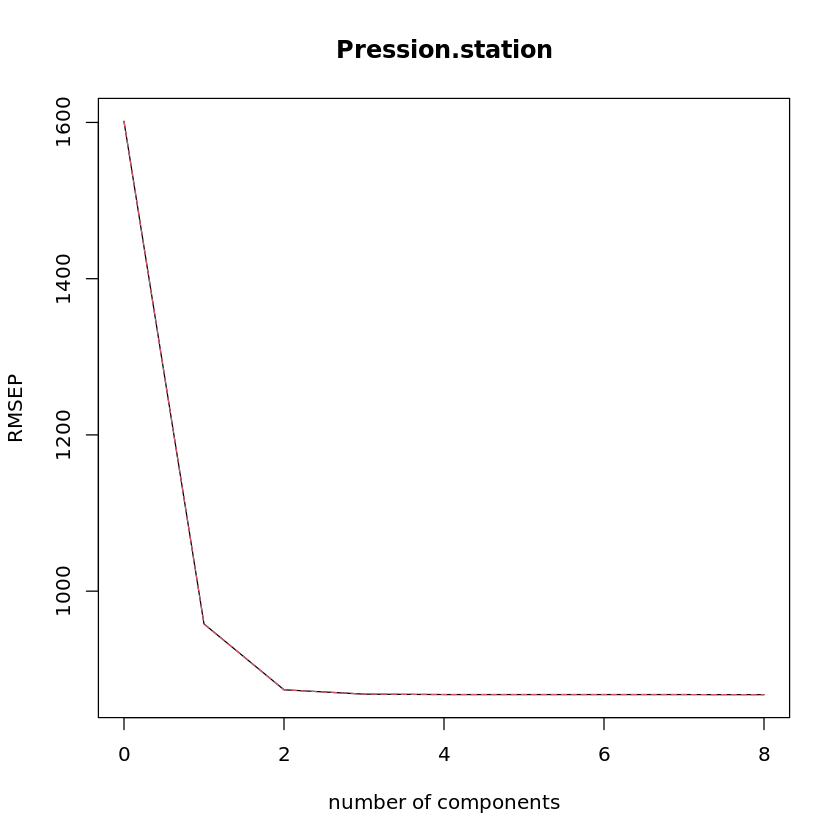

In [5]:
pls_temp <- plsr(Pression.station ~ ., data = data_clean, scale = TRUE, validation = "CV")
summary(pls_temp)
validationplot(pls_temp, val.type="RMSEP")

loadings <- loading.weights(pls_temp)
loadings


Analyse des composantes principales:

$C1$: Majoritairement pondérée par l'altitude avec un signe négatif, permettant de confirmer le fait que la pression décroit en majeure partie du à l'élévation de la station.

$C2$: Principalement pondérée négativement par la température et le point de rosée positivement par l'humidité. On pourrait interpéter cette composante comme la "lourdeur de l'air"